<a href="https://colab.research.google.com/github/annahanslc/koi-price-prediction/blob/main/3_Modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Koi Variety Classification

--------
### Notebook # 3 - Modeling


--------

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os, sys, glob, shutil

import keras
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

from sklearn.model_selection import train_test_split

-------
# Load Data

-------

In [ ]:
# Mount google drive

from google.colab import drive
drive.mount('/content/drive')

# Define dataset path

drive_path = "/content/drive/MyDrive/Colab Notebooks/project_koi_classification/data"

# Set up file path for function files

sys.path.append("/content/drive/MyDrive/Colab Notebooks/project_koi_classification/src")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Import helper functions

from helpers import *
from deep_functions import *

In [ ]:
# Copy folder from google drive to local storage for faster processing unless folder is already there

drive_path = "/content/drive/MyDrive/Colab Notebooks/project_koi_classification/data"
local_path = "/content/koi_data"


if not os.path.exists(local_path):
    shutil.copytree(drive_path, local_path)
    print(f"Dataset copied to local storage at: {local_path}")
else:
    print(f"Dataset already exists at: {local_path}")

Dataset already exists at: /content/koi_data


-------
# Train/Test/Val Split

-------

In [ ]:
# Split into train/test/val

image_paths = []
labels = []

class_names = sorted(os.listdir(local_path))  # sorted ensures label consistency

# Get the file paths and labels manually

for label, class_name in enumerate(class_names):
    class_dir = os.path.join(local_path, class_name)
    if os.path.isdir(class_dir):
        for img_file in glob.glob(os.path.join(class_dir, "*")):
            if img_file.lower().endswith(('.jpg', '.jpeg', '.png')):
                image_paths.append(img_file)
                labels.append(label)

# Create a dictionary to map class names to their label

class_dict = {i: class_name for i, class_name in enumerate(class_names)}
class_dict

# First split: train vs (val + test)
X_train_paths, X_test_paths, y_train, y_test = train_test_split(image_paths, labels, test_size=0.3, stratify=labels, random_state=42)

# Second split: train vs val
X_test_paths, X_val_paths, y_test, y_val = train_test_split(X_test_paths, y_test, test_size=0.5, stratify=y_test, random_state=42)

# Check the shapes

print(f"""
X_train length: {len(X_train_paths)}, y_train length: {len(y_train)}
X_test length: {len(X_test_paths)}, y_test length: {len(y_test)}
X_val length: {len(X_val_paths)}, y_val length: {len(y_val)}
""")

# Define constant variables

IMG_SIZE = (224, 224)
INPUT_SHAPE = (224, 224, 3)
BATCH_SIZE = 16

# Create a function to process images into raw tensor

def process_image(file_path, label):
  img = tf.io.read_file(file_path)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.resize(img, IMG_SIZE)
  img.set_shape(INPUT_SHAPE)

  return img, label

# Use the process_image function on all data sets

X_train_raw, y_train = zip(*[process_image(path, label) for path, label in zip(X_train_paths, y_train)])
X_test_raw, y_test = zip(*[process_image(path, label) for path, label in zip(X_test_paths, y_test)])
X_val_raw, y_val = zip(*[process_image(path, label) for path, label in zip(X_val_paths, y_val)])

# Create tensorflow dataset using the raw tensors

train_ds = tf.data.Dataset.from_tensor_slices((list(X_train_raw), list(y_train)))
test_ds = tf.data.Dataset.from_tensor_slices((list(X_test_raw), list(y_test)))
val_ds = tf.data.Dataset.from_tensor_slices((list(X_val_raw), list(y_val)))

# Optimize the datasets

train_ds = train_ds.cache().shuffle(len(X_train_raw)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.cache().batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.cache().batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)



X_train length: 565, y_train length: 565
X_test length: 121, y_test length: 121
X_val length: 122, y_val length: 122



-------
# Model #1: Regularized Base Model

### a) Augmentation: RandomFlip, RandomRotation, RandomZoom, RandomTranslation

### b) Regularization: Dropout, BatchNormalization

-------

In [ ]:
# Use ResNet for transfer learning for baseline model

resnet50v2_pretrained = keras.applications.ResNet50V2(include_top=False,
                                           weights="imagenet",
                                           input_tensor=None,
                                           input_shape=INPUT_SHAPE,
                                           pooling='avg',
                                           name="resnet50v2",
                                           )

resnet50v2_pretrained.trainable = False

# Use ResNet50V2's preprocessing

from tensorflow.keras.applications.resnet_v2 import preprocess_input

resnetv2_preprocessor = preprocess_input

In [ ]:
# Define a data augmentation layer

data_augmentation = tf.keras.Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.5),
    RandomZoom(0.1),
    RandomTranslation(0.1, 0.1)
], name='data_augmentation')


# Build model

def build_model_1_reg():
  model = Sequential()
  model.add(Input(shape=INPUT_SHAPE))
  model.add(data_augmentation)
  model.add(Lambda(resnetv2_preprocessor))
  model.add(resnet50v2_pretrained)
  model.add(Dense(16, activation=None))
  model.add(BatchNormalization())
  model.add(ReLU())
  model.add(Dropout(0.1))
  model.add(Dense(len(class_names), activation='softmax'))

  model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

  model.summary()
  return model


# Make an instance of the model

model_1_reg = build_model_1_reg()
model_1_reg.summary()

Model: "sequential_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ data_augmentation (Sequential)  │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_18 (Lambda)              │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50v2 (Functional)         │ (None, 2048)           │    23,564,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_43 (Dense)                │ (None, 16)             │        32,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_22          │ (None, 16)             │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_22 (ReLU)                 │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_44 (Dense)                │ (None, 10)             │           170 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,597,818 (90.02 MB)

 Trainable params: 32,986 (128.85 KB)

 Non-trainable params: 23,564,832 (89.89 MB)

Model: "sequential_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ data_augmentation (Sequential)  │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_18 (Lambda)              │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50v2 (Functional)         │ (None, 2048)           │    23,564,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_43 (Dense)                │ (None, 16)             │        32,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_22          │ (None, 16)             │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_22 (ReLU)                 │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_44 (Dense)                │ (None, 10)             │           170 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,597,818 (90.02 MB)

 Trainable params: 32,986 (128.85 KB)

 Non-trainable params: 23,564,832 (89.89 MB)

In [ ]:
# Fit the model

history_1 = model_1_reg.fit(train_ds, validation_data=test_ds, epochs=50,
                        callbacks=[EarlyStopping(patience=3, restore_best_weights=True)])

Epoch 1/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 11s 89ms/step - accuracy: 0.2690 - loss: 2.1468 - val_accuracy: 0.3967 - val_loss: 1.7863
Epoch 2/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.4878 - loss: 1.5945 - val_accuracy: 0.5289 - val_loss: 1.4619
Epoch 3/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.5508 - loss: 1.4362 - val_accuracy: 0.5950 - val_loss: 1.2988
Epoch 4/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.6278 - loss: 1.2758 - val_accuracy: 0.5868 - val_loss: 1.2091
Epoch 5/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.6579 - loss: 1.1729 - val_accuracy: 0.6198 - val_loss: 1.1150
Epoch 6/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.7188 - loss: 1.0911 - val_accuracy: 0.6694 - val_loss: 1.0780
Epoch 7/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.7110 - loss: 1.0429 - val_accuracy: 0.6942 - val_loss: 0.9786
Epoch 8/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.7456 - loss: 0.9911 - val_accuracy: 0.7273 - 


- Evaluating Network...
----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.94      0.98      0.96        48
           1       0.91      0.93      0.92        42
           2       0.90      1.00      0.95        75
           3       0.86      0.50      0.63        38
           4       0.86      0.90      0.88        78
           5       0.86      0.94      0.89        63
           6       0.93      0.87      0.90        76
           7       0.98      0.98      0.98        44
           8       0.84      0.74      0.79        57
           9       0.85      1.00      0.92        44

    accuracy                           0.89       565
   macro avg       0.89      0.88      0.88       565
weighted avg       0.89      0.89      0.89       565



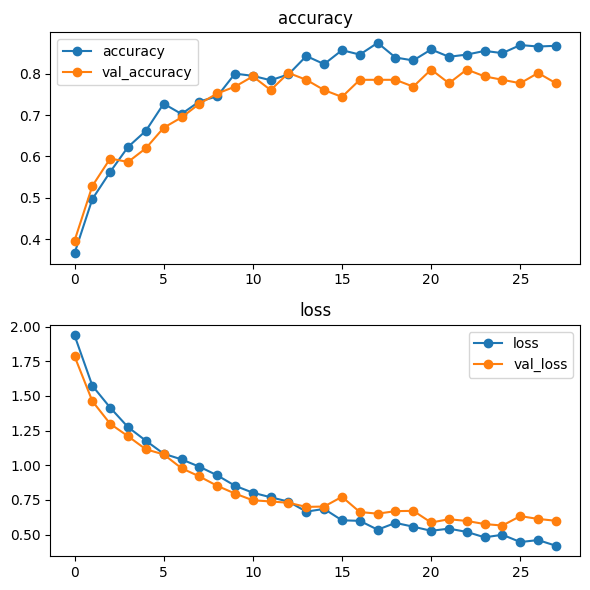

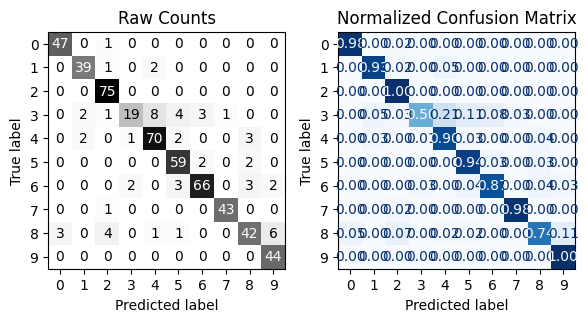

----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.73      0.80      0.76        10
           1       0.86      0.67      0.75         9
           2       0.73      1.00      0.84        16
           3       1.00      0.56      0.71         9
           4       0.93      0.81      0.87        16
           5       0.75      0.92      0.83        13
           6       0.75      0.75      0.75        16
           7       0.83      1.00      0.91        10
           8       0.80      0.33      0.47        12
           9       0.69      0.90      0.78        10

    accuracy                           0.79       121
   macro avg       0.81      0.77      0.77       121
weighted avg       0.80      0.79      0.77       121



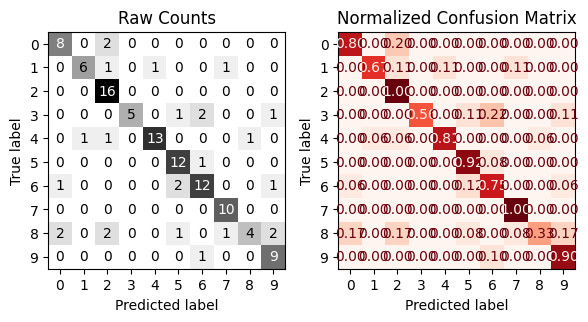

precision    recall  f1-score     support
Train 0              0.940000  0.979167  0.959184   48.000000
      1              0.906977  0.928571  0.917647   42.000000
      2              0.903614  1.000000  0.949367   75.000000
      3              0.863636  0.500000  0.633333   38.000000
      4              0.864198  0.897436  0.880503   78.000000
      5              0.855072  0.936508  0.893939   63.000000
      6              0.929577  0.868421  0.897959   76.000000
      7              0.977273  0.977273  0.977273   44.000000
      8              0.840000  0.736842  0.785047   57.000000
      9              0.846154  1.000000  0.916667   44.000000
      accuracy       0.892035  0.892035  0.892035    0.892035
      macro avg      0.892650  0.882422  0.881092  565.000000
      weighted avg   0.891749  0.892035  0.887035  565.000000
Test  0              0.727273  0.800000  0.761905   10.000000
      1              0.857143  0.666667  0.750000    9.000000
      2              0.727273  1.000000  0.842105   16.000000
      3              1.000000  0.555556  0.714286    9.000000
      4              0.928571  0.812500  0.866667   16.000000
      5              0.750000  0.923077  0.827586   13.000000
      6              0.750000  0.750000  0.750000   16.000000
      7              0.833333  1.000000  0.909091   10.000000
      8              0.800000  0.333333  0.470588   12.000000
      9              0.692308  0.900000  0.782609   10.000000
      accuracy       0.785124  0.785124  0.785124    0.785124
      macro avg      0.806590  0.774113  0.767484  121.000000
      weighted avg   0.802371  0.785124  0.772402  121.000000

In [ ]:
# Evaluate the results

train_dict, test_dict = evaluate_classification_network(model_1_reg,
                                                        X_train=train_ds,
                                                        X_test=test_ds,
                                                        history=history_1,
                                                        output_dict=True)

# Use helper function to get results in a DataFrame

results_model_1 = make_results_df(train_dict, test_dict)
results_model_1

-------
# Model #2: More Units

### a) Augmentation: RandomFlip, RandomRotation, RandomZoom, RandomTranslation

### b) Regularization: Dropout, BatchNormalization

### c) (NEW) More Units to introduce Complexity
-------

In [ ]:
# Define a data augmentation layer

data_augmentation = tf.keras.Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.5),
    RandomZoom(0.1),
    RandomTranslation(0.1, 0.1)
], name='data_augmentation')


# Build model

def build_model_2_64units():
  model = Sequential()
  model.add(Input(shape=INPUT_SHAPE))
  model.add(data_augmentation)
  model.add(Lambda(resnetv2_preprocessor))
  model.add(resnet50v2_pretrained)
  model.add(Dense(64, activation=None))
  model.add(BatchNormalization())
  model.add(ReLU())
  model.add(Dropout(0.1))
  model.add(Dense(len(class_names), activation='softmax'))

  model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

  model.summary()
  return model


# Make an instance of the model

model_2_64units = build_model_2_64units()
model_2_64units.summary()

Model: "sequential_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ data_augmentation (Sequential)  │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_19 (Lambda)              │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50v2 (Functional)         │ (None, 2048)           │    23,564,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_45 (Dense)                │ (None, 64)             │       131,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_23          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_23 (ReLU)                 │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_46 (Dense)                │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,696,842 (90.40 MB)

 Trainable params: 131,914 (515.29 KB)

 Non-trainable params: 23,564,928 (89.89 MB)

Model: "sequential_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ data_augmentation (Sequential)  │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_19 (Lambda)              │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50v2 (Functional)         │ (None, 2048)           │    23,564,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_45 (Dense)                │ (None, 64)             │       131,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_23          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_23 (ReLU)                 │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_46 (Dense)                │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,696,842 (90.40 MB)

 Trainable params: 131,914 (515.29 KB)

 Non-trainable params: 23,564,928 (89.89 MB)

In [ ]:
# Fit the model

history_2 = model_2_64units.fit(train_ds, validation_data=test_ds, epochs=50,
                                callbacks=[EarlyStopping(patience=3, restore_best_weights=True)])

Epoch 1/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 10s 87ms/step - accuracy: 0.3549 - loss: 1.8183 - val_accuracy: 0.6612 - val_loss: 0.9938
Epoch 2/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.7412 - loss: 0.9273 - val_accuracy: 0.8017 - val_loss: 0.7788
Epoch 3/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.7640 - loss: 0.7964 - val_accuracy: 0.8099 - val_loss: 0.7238
Epoch 4/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.8061 - loss: 0.6310 - val_accuracy: 0.7851 - val_loss: 0.6711
Epoch 5/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.8327 - loss: 0.5722 - val_accuracy: 0.7934 - val_loss: 0.6338
Epoch 6/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.8557 - loss: 0.5364 - val_accuracy: 0.8017 - val_loss: 0.5599
Epoch 7/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.8605 - loss: 0.5072 - val_accuracy: 0.8017 - val_loss: 0.5738
Epoch 8/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.8538 - loss: 0.5384 - val_accuracy: 0.7769 - 


- Evaluating Network...
----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.92      0.96      0.94        48
           1       0.95      0.88      0.91        42
           2       0.93      0.99      0.95        75
           3       0.85      0.58      0.69        38
           4       0.90      0.88      0.89        78
           5       0.73      0.92      0.82        63
           6       0.83      0.76      0.79        76
           7       0.94      1.00      0.97        44
           8       0.81      0.67      0.73        57
           9       0.78      0.89      0.83        44

    accuracy                           0.86       565
   macro avg       0.86      0.85      0.85       565
weighted avg       0.86      0.86      0.86       565



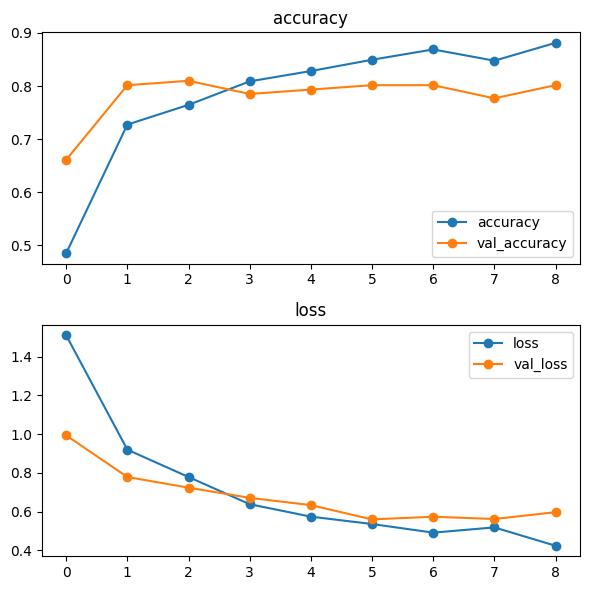

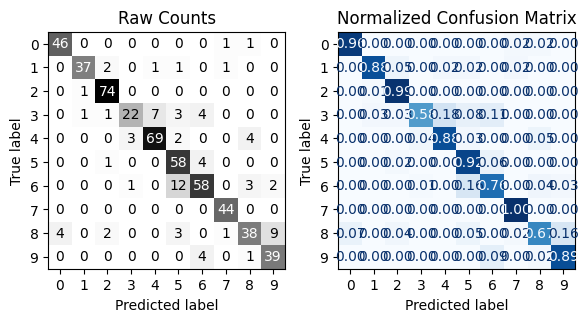

----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.80      0.80      0.80        10
           1       0.88      0.78      0.82         9
           2       0.76      1.00      0.86        16
           3       1.00      0.44      0.62         9
           4       1.00      0.88      0.93        16
           5       0.63      0.92      0.75        13
           6       0.81      0.81      0.81        16
           7       0.83      1.00      0.91        10
           8       0.75      0.25      0.38        12
           9       0.77      1.00      0.87        10

    accuracy                           0.80       121
   macro avg       0.82      0.79      0.78       121
weighted avg       0.82      0.80      0.78       121



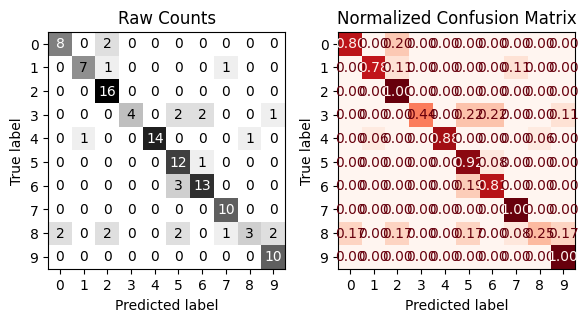

precision    recall  f1-score     support
Train 0              0.920000  0.958333  0.938776   48.000000
      1              0.948718  0.880952  0.913580   42.000000
      2              0.925000  0.986667  0.954839   75.000000
      3              0.846154  0.578947  0.687500   38.000000
      4              0.896104  0.884615  0.890323   78.000000
      5              0.734177  0.920635  0.816901   63.000000
      6              0.828571  0.763158  0.794521   76.000000
      7              0.936170  1.000000  0.967033   44.000000
      8              0.808511  0.666667  0.730769   57.000000
      9              0.780000  0.886364  0.829787   44.000000
      accuracy       0.858407  0.858407  0.858407    0.858407
      macro avg      0.862341  0.852634  0.852403  565.000000
      weighted avg   0.860624  0.858407  0.855180  565.000000
Test  0              0.800000  0.800000  0.800000   10.000000
      1              0.875000  0.777778  0.823529    9.000000
      2              0.761905  1.000000  0.864865   16.000000
      3              1.000000  0.444444  0.615385    9.000000
      4              1.000000  0.875000  0.933333   16.000000
      5              0.631579  0.923077  0.750000   13.000000
      6              0.812500  0.812500  0.812500   16.000000
      7              0.833333  1.000000  0.909091   10.000000
      8              0.750000  0.250000  0.375000   12.000000
      9              0.769231  1.000000  0.869565   10.000000
      accuracy       0.801653  0.801653  0.801653    0.801653
      macro avg      0.823355  0.788280  0.775327  121.000000
      weighted avg   0.820675  0.801653  0.783124  121.000000

In [ ]:
# Evaluate the results

train_dict, test_dict = evaluate_classification_network(model_2_64units,
                                                        X_train=train_ds,
                                                        X_test=test_ds,
                                                        history=history_2,
                                                        output_dict=True)

# Use helper function to get results in a DataFrame

results_model_2 = make_results_df(train_dict, test_dict)
results_model_2

In [ ]:
# Use helper function to compare the current model with the best previous model (model #3)

compare_models(results_model_1, results_model_2)

Train accuracy decreased by -0.03362831858407078
Test accuracy increased by 0.016528925619834656
Overfitting decreased by -0.05015724420390544
*Overfitting is calculated as train accuracy - test acccuracy


-------
# Model #3: More Layers

### a) Augmentation: RandomFlip, RandomRotation, RandomZoom, RandomTranslation

### b) Regularization: Dropout, BatchNormalization

### c) (KEEP) More Units to introduce Complexity

### d) (NEW) Add more Layer to add Complexity
-------

In [ ]:
# Define a data augmentation layer

data_augmentation = tf.keras.Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.5),
    RandomZoom(0.1),
    RandomTranslation(0.1, 0.1)
], name='data_augmentation')


# Build model

def build_model_3_layers():
  model = Sequential()
  model.add(Input(shape=INPUT_SHAPE))
  model.add(data_augmentation)
  model.add(Lambda(resnetv2_preprocessor))
  model.add(resnet50v2_pretrained)
  model.add(Dense(64, activation=None))
  model.add(BatchNormalization())
  model.add(ReLU())
  model.add(Dropout(0.1))
  model.add(Dense(64, activation=None))
  model.add(BatchNormalization())
  model.add(ReLU())
  model.add(Dropout(0.1))
  model.add(Dense(len(class_names), activation='softmax'))

  model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

  model.summary()
  return model


# Make an instance of the model

model_3_layers = build_model_3_layers()
model_3_layers.summary()

Model: "sequential_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ data_augmentation (Sequential)  │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_20 (Lambda)              │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50v2 (Functional)         │ (None, 2048)           │    23,564,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_47 (Dense)                │ (None, 64)             │       131,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_24          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_24 (ReLU)                 │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_48 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_25          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_25 (ReLU)                 │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_49 (Dense)                │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,701,258 (90.41 MB)

 Trainable params: 136,202 (532.04 KB)

 Non-trainable params: 23,565,056 (89.89 MB)

Model: "sequential_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ data_augmentation (Sequential)  │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_20 (Lambda)              │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50v2 (Functional)         │ (None, 2048)           │    23,564,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_47 (Dense)                │ (None, 64)             │       131,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_24          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_24 (ReLU)                 │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_48 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_25          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_25 (ReLU)                 │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_49 (Dense)                │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,701,258 (90.41 MB)

 Trainable params: 136,202 (532.04 KB)

 Non-trainable params: 23,565,056 (89.89 MB)

In [ ]:
# Fit the model

history_3 = model_3_layers.fit(train_ds, validation_data=test_ds, epochs=50,
                                callbacks=[EarlyStopping(patience=3, restore_best_weights=True)])

Epoch 1/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 11s 89ms/step - accuracy: 0.2539 - loss: 2.1404 - val_accuracy: 0.4545 - val_loss: 1.6163
Epoch 2/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.6184 - loss: 1.2550 - val_accuracy: 0.6446 - val_loss: 1.0797
Epoch 3/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.6861 - loss: 1.0436 - val_accuracy: 0.7851 - val_loss: 0.8351
Epoch 4/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.7476 - loss: 0.8524 - val_accuracy: 0.7521 - val_loss: 0.7594
Epoch 5/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.7438 - loss: 0.8012 - val_accuracy: 0.7521 - val_loss: 0.7343
Epoch 6/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.8170 - loss: 0.6720 - val_accuracy: 0.7851 - val_loss: 0.6656
Epoch 7/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.7711 - loss: 0.7165 - val_accuracy: 0.7273 - val_loss: 0.7042
Epoch 8/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.8093 - loss: 0.6029 - val_accuracy: 0.7603 - 


- Evaluating Network...
----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.77      0.87        48
           1       0.91      0.93      0.92        42
           2       0.88      0.99      0.93        75
           3       0.82      0.47      0.60        38
           4       0.89      0.86      0.88        78
           5       0.87      0.86      0.86        63
           6       0.82      0.92      0.87        76
           7       1.00      0.98      0.99        44
           8       0.74      0.79      0.76        57
           9       0.79      0.95      0.87        44

    accuracy                           0.87       565
   macro avg       0.87      0.85      0.85       565
weighted avg       0.87      0.87      0.86       565



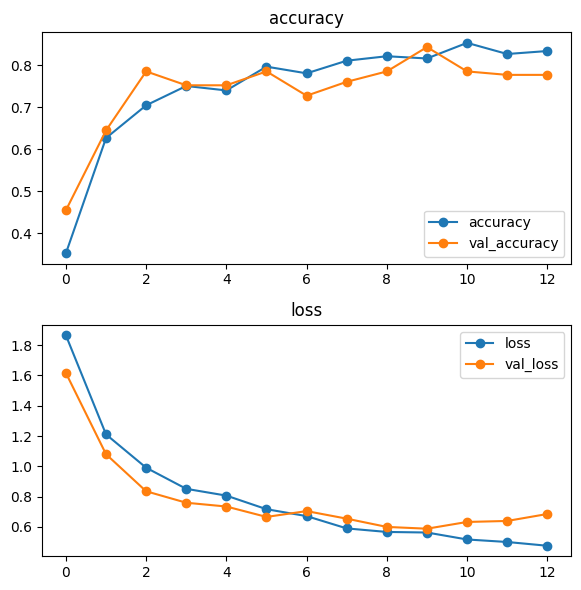

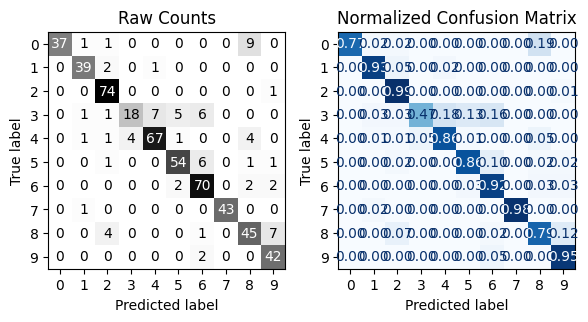

----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.89      0.80      0.84        10
           1       1.00      0.67      0.80         9
           2       0.73      1.00      0.84        16
           3       1.00      0.67      0.80         9
           4       0.94      0.94      0.94        16
           5       0.75      0.69      0.72        13
           6       0.83      0.94      0.88        16
           7       0.91      1.00      0.95        10
           8       0.88      0.58      0.70        12
           9       0.77      1.00      0.87        10

    accuracy                           0.84       121
   macro avg       0.87      0.83      0.83       121
weighted avg       0.86      0.84      0.84       121



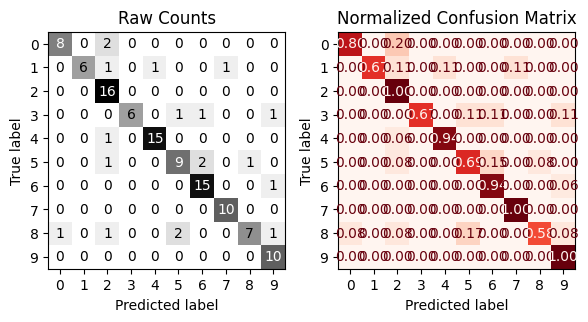

precision    recall  f1-score     support
Train 0              1.000000  0.770833  0.870588   48.000000
      1              0.906977  0.928571  0.917647   42.000000
      2              0.880952  0.986667  0.930818   75.000000
      3              0.818182  0.473684  0.600000   38.000000
      4              0.893333  0.858974  0.875817   78.000000
      5              0.870968  0.857143  0.864000   63.000000
      6              0.823529  0.921053  0.869565   76.000000
      7              1.000000  0.977273  0.988506   44.000000
      8              0.737705  0.789474  0.762712   57.000000
      9              0.792453  0.954545  0.865979   44.000000
      accuracy       0.865487  0.865487  0.865487    0.865487
      macro avg      0.872410  0.851822  0.854563  565.000000
      weighted avg   0.869578  0.865487  0.861673  565.000000
Test  0              0.888889  0.800000  0.842105   10.000000
      1              1.000000  0.666667  0.800000    9.000000
      2              0.727273  1.000000  0.842105   16.000000
      3              1.000000  0.666667  0.800000    9.000000
      4              0.937500  0.937500  0.937500   16.000000
      5              0.750000  0.692308  0.720000   13.000000
      6              0.833333  0.937500  0.882353   16.000000
      7              0.909091  1.000000  0.952381   10.000000
      8              0.875000  0.583333  0.700000   12.000000
      9              0.769231  1.000000  0.869565   10.000000
      accuracy       0.842975  0.842975  0.842975    0.842975
      macro avg      0.869032  0.828397  0.834601  121.000000
      weighted avg   0.858610  0.842975  0.837949  121.000000

In [ ]:
# Evaluate the results

train_dict, test_dict = evaluate_classification_network(model_3_layers,
                                                        X_train=train_ds,
                                                        X_test=test_ds,
                                                        history=history_3,
                                                        output_dict=True)

# Use helper function to get results in a DataFrame

results_model_3 = make_results_df(train_dict, test_dict)
results_model_3

In [ ]:
# Use helper function to compare the current model with the best previous model (model #3)

compare_models(results_model_2, results_model_3)

Train accuracy increased by 0.0070796460176990594
Test accuracy increased by 0.04132231404958675
Overfitting decreased by -0.03424266803188769
*Overfitting is calculated as train accuracy - test acccuracy


-------
# Model #4: More Complexity

### a) Augmentation: RandomFlip, RandomRotation, RandomZoom, RandomTranslation

### b) Regularization: Dropout, BatchNormalization

### c) (KEEP) More Units to introduce Complexity

### d) (KEEP) Add more Layer to add Complexity

### e) (NEW) Add more Units and more Layers
-------

In [ ]:
# Define a data augmentation layer

data_augmentation = tf.keras.Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.5),
    RandomZoom(0.1),
    RandomTranslation(0.1, 0.1)
], name='data_augmentation')


# Build model

def build_model_4_complex():
  model = Sequential()
  model.add(Input(shape=INPUT_SHAPE))
  model.add(data_augmentation)
  model.add(Lambda(resnetv2_preprocessor))
  model.add(resnet50v2_pretrained)
  model.add(Dense(128, activation=None))
  model.add(BatchNormalization())
  model.add(ReLU())
  model.add(Dropout(0.1))
  model.add(Dense(128, activation=None))
  model.add(BatchNormalization())
  model.add(ReLU())
  model.add(Dropout(0.1))
  model.add(Dense(128, activation=None))
  model.add(BatchNormalization())
  model.add(ReLU())
  model.add(Dropout(0.1))
  model.add(Dense(len(class_names), activation='softmax'))

  model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

  model.summary()
  return model


# Make an instance of the model

model_4_complex = build_model_4_complex()
model_4_complex.summary()

Model: "sequential_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ data_augmentation (Sequential)  │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_21 (Lambda)              │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50v2 (Functional)         │ (None, 2048)           │    23,564,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_50 (Dense)                │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_26          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_26 (ReLU)                 │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_27 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_51 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_27          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_27 (ReLU)                 │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_28 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_52 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_28          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_28 (ReLU)                 │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_29 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_53 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,862,922 (91.03 MB)

 Trainable params: 297,354 (1.13 MB)

 Non-trainable params: 23,565,568 (89.90 MB)

Model: "sequential_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ data_augmentation (Sequential)  │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_21 (Lambda)              │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50v2 (Functional)         │ (None, 2048)           │    23,564,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_50 (Dense)                │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_26          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_26 (ReLU)                 │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_27 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_51 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_27          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_27 (ReLU)                 │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_28 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_52 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_28          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_28 (ReLU)                 │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_29 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_53 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,862,922 (91.03 MB)

 Trainable params: 297,354 (1.13 MB)

 Non-trainable params: 23,565,568 (89.90 MB)

In [ ]:
# Fit the model

history_4 = model_4_complex.fit(train_ds, validation_data=test_ds, epochs=50,
                                callbacks=[EarlyStopping(patience=3, restore_best_weights=True)])

Epoch 1/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 12s 90ms/step - accuracy: 0.2774 - loss: 2.1779 - val_accuracy: 0.6364 - val_loss: 1.3469
Epoch 2/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.6268 - loss: 1.1977 - val_accuracy: 0.6777 - val_loss: 0.9644
Epoch 3/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.7359 - loss: 0.8583 - val_accuracy: 0.7934 - val_loss: 0.7561
Epoch 4/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.7012 - loss: 0.8211 - val_accuracy: 0.7603 - val_loss: 0.6770
Epoch 5/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.7565 - loss: 0.7495 - val_accuracy: 0.8017 - val_loss: 0.6387
Epoch 6/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.7797 - loss: 0.6941 - val_accuracy: 0.8182 - val_loss: 0.5310
Epoch 7/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.8171 - loss: 0.5923 - val_accuracy: 0.8099 - val_loss: 0.5429
Epoch 8/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.8418 - loss: 0.5003 - val_accuracy: 0.8264 - 


- Evaluating Network...
----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.91      0.90      0.91        48
           1       0.86      0.86      0.86        42
           2       0.81      0.99      0.89        75
           3       0.73      0.71      0.72        38
           4       0.92      0.88      0.90        78
           5       0.85      0.84      0.85        63
           6       0.80      0.86      0.83        76
           7       0.97      0.84      0.90        44
           8       0.85      0.79      0.82        57
           9       0.87      0.77      0.82        44

    accuracy                           0.85       565
   macro avg       0.86      0.84      0.85       565
weighted avg       0.86      0.85      0.85       565



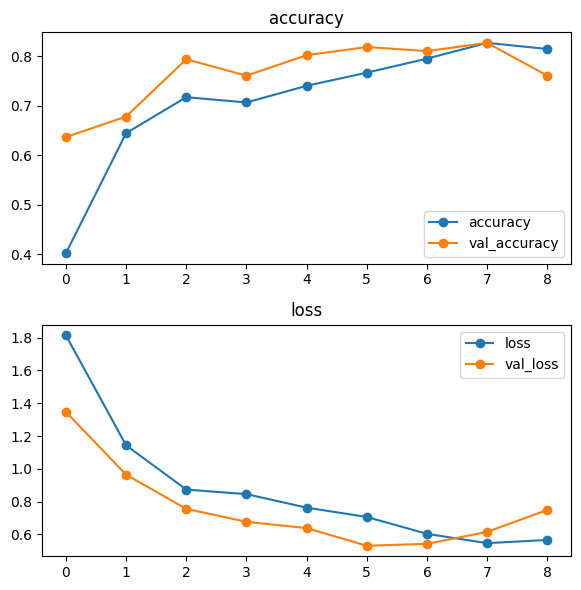

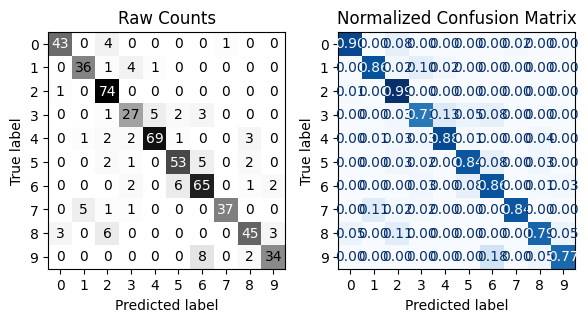

----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.78      0.70      0.74        10
           1       0.80      0.89      0.84         9
           2       0.73      1.00      0.84        16
           3       0.80      0.89      0.84         9
           4       1.00      0.88      0.93        16
           5       0.79      0.85      0.81        13
           6       0.81      0.81      0.81        16
           7       0.89      0.80      0.84        10
           8       0.75      0.50      0.60        12
           9       0.89      0.80      0.84        10

    accuracy                           0.82       121
   macro avg       0.82      0.81      0.81       121
weighted avg       0.82      0.82      0.81       121



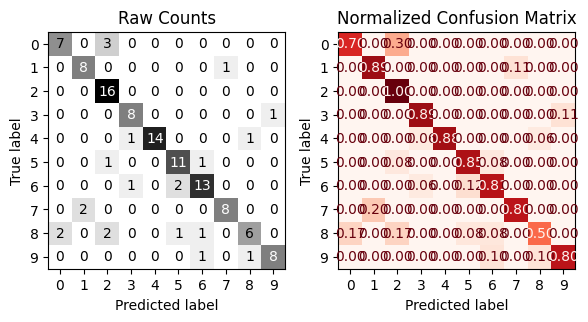

precision    recall  f1-score     support
Train 0              0.914894  0.895833  0.905263   48.000000
      1              0.857143  0.857143  0.857143   42.000000
      2              0.813187  0.986667  0.891566   75.000000
      3              0.729730  0.710526  0.720000   38.000000
      4              0.920000  0.884615  0.901961   78.000000
      5              0.854839  0.841270  0.848000   63.000000
      6              0.802469  0.855263  0.828025   76.000000
      7              0.973684  0.840909  0.902439   44.000000
      8              0.849057  0.789474  0.818182   57.000000
      9              0.871795  0.772727  0.819277   44.000000
      accuracy       0.854867  0.854867  0.854867    0.854867
      macro avg      0.858680  0.843443  0.849186  565.000000
      weighted avg   0.858112  0.854867  0.854476  565.000000
Test  0              0.777778  0.700000  0.736842   10.000000
      1              0.800000  0.888889  0.842105    9.000000
      2              0.727273  1.000000  0.842105   16.000000
      3              0.800000  0.888889  0.842105    9.000000
      4              1.000000  0.875000  0.933333   16.000000
      5              0.785714  0.846154  0.814815   13.000000
      6              0.812500  0.812500  0.812500   16.000000
      7              0.888889  0.800000  0.842105   10.000000
      8              0.750000  0.500000  0.600000   12.000000
      9              0.888889  0.800000  0.842105   10.000000
      accuracy       0.818182  0.818182  0.818182    0.818182
      macro avg      0.823104  0.811143  0.810802  121.000000
      weighted avg   0.824845  0.818182  0.814612  121.000000

In [ ]:
# Evaluate the results

train_dict, test_dict = evaluate_classification_network(model_4_complex,
                                                        X_train=train_ds,
                                                        X_test=test_ds,
                                                        history=history_4,
                                                        output_dict=True)

# Use helper function to get results in a DataFrame

results_model_4 = make_results_df(train_dict, test_dict)
results_model_4

In [ ]:
# Use helper function to compare the current model with the best previous model (model #3)

compare_models(results_model_3, results_model_4)

Train accuracy decreased by -0.010619469026548645
Test accuracy decreased by -0.024793388429751984
Overfitting increased by 0.014173919403203339
*Overfitting is calculated as train accuracy - test acccuracy


Observation:

Performance has decreased, and overfitting increased. The model is too complex. I will reduce the number of units.

-------
# Model #5: Reduce Complexity

### a) Augmentation: RandomFlip, RandomRotation, RandomZoom, RandomTranslation

### b) Regularization: Dropout, BatchNormalization

### c) (KEEP) More Units to introduce Complexity

### d) (KEEP) Add more Layer to add Complexity

### e) (KEEP PART) Add more Layers, reduce number of Units in a funnel-shape
-------

In [ ]:
# Define a data augmentation layer

data_augmentation = tf.keras.Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.5),
    RandomZoom(0.1),
    RandomTranslation(0.1, 0.1)
], name='data_augmentation')


# Build model

def build_model_5_reduce():
  model = Sequential()
  model.add(Input(shape=INPUT_SHAPE))
  model.add(data_augmentation)
  model.add(Lambda(resnetv2_preprocessor))
  model.add(resnet50v2_pretrained)
  model.add(Dense(128, activation=None))
  model.add(BatchNormalization())
  model.add(ReLU())
  model.add(Dropout(0.1))
  model.add(Dense(64, activation=None))
  model.add(BatchNormalization())
  model.add(ReLU())
  model.add(Dropout(0.1))
  model.add(Dense(32, activation=None))
  model.add(BatchNormalization())
  model.add(ReLU())
  model.add(Dropout(0.1))
  model.add(Dense(len(class_names), activation='softmax'))

  model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

  model.summary()
  return model


# Make an instance of the model

model_5_reduce = build_model_5_reduce()
model_5_reduce.summary()

Model: "sequential_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ data_augmentation (Sequential)  │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_22 (Lambda)              │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50v2 (Functional)         │ (None, 2048)           │    23,564,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_54 (Dense)                │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_29          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_29 (ReLU)                 │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_30 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_55 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_30          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_30 (ReLU)                 │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_31 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_56 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_31          │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_31 (ReLU)                 │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_32 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_57 (Dense)                │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,838,634 (90.94 MB)

 Trainable params: 273,386 (1.04 MB)

 Non-trainable params: 23,565,248 (89.89 MB)

Model: "sequential_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ data_augmentation (Sequential)  │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_22 (Lambda)              │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50v2 (Functional)         │ (None, 2048)           │    23,564,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_54 (Dense)                │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_29          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_29 (ReLU)                 │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_30 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_55 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_30          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_30 (ReLU)                 │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_31 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_56 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_31          │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_31 (ReLU)                 │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_32 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_57 (Dense)                │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,838,634 (90.94 MB)

 Trainable params: 273,386 (1.04 MB)

 Non-trainable params: 23,565,248 (89.89 MB)

In [ ]:
# Fit the model

history_5 = model_5_reduce.fit(train_ds, validation_data=test_ds, epochs=50,
                                callbacks=[EarlyStopping(patience=3, restore_best_weights=True)])

Epoch 1/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 14s 93ms/step - accuracy: 0.1806 - loss: 2.2785 - val_accuracy: 0.4793 - val_loss: 1.6122
Epoch 2/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.5187 - loss: 1.5213 - val_accuracy: 0.6116 - val_loss: 1.2077
Epoch 3/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.6440 - loss: 1.2928 - val_accuracy: 0.7355 - val_loss: 1.0047
Epoch 4/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.7398 - loss: 1.0834 - val_accuracy: 0.7521 - val_loss: 0.9327
Epoch 5/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.7453 - loss: 0.9904 - val_accuracy: 0.7438 - val_loss: 0.7850
Epoch 6/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.7497 - loss: 0.8773 - val_accuracy: 0.7686 - val_loss: 0.7496
Epoch 7/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.7741 - loss: 0.7934 - val_accuracy: 0.7851 - val_loss: 0.7166
Epoch 8/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.7810 - loss: 0.7216 - val_accuracy: 0.7686 - 


- Evaluating Network...
----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.80      0.98      0.88        48
           1       0.77      0.95      0.85        42
           2       0.92      0.96      0.94        75
           3       0.89      0.45      0.60        38
           4       0.91      0.79      0.85        78
           5       0.86      0.81      0.84        63
           6       0.79      0.92      0.85        76
           7       0.95      0.95      0.95        44
           8       0.86      0.67      0.75        57
           9       0.77      0.93      0.85        44

    accuracy                           0.85       565
   macro avg       0.85      0.84      0.84       565
weighted avg       0.86      0.85      0.84       565



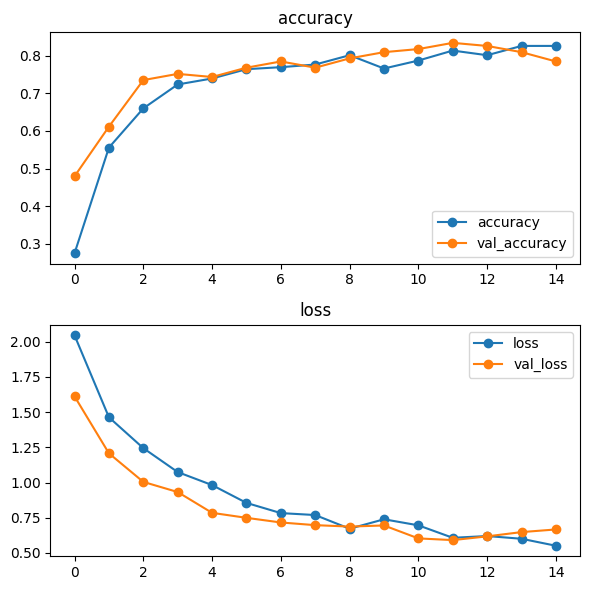

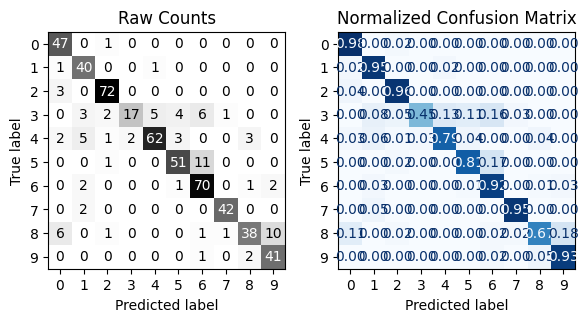

----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.77      1.00      0.87        10
           1       0.89      0.89      0.89         9
           2       0.88      0.94      0.91        16
           3       1.00      0.56      0.71         9
           4       1.00      0.88      0.93        16
           5       0.83      0.77      0.80        13
           6       0.78      0.88      0.82        16
           7       0.83      1.00      0.91        10
           8       0.83      0.42      0.56        12
           9       0.67      1.00      0.80        10

    accuracy                           0.83       121
   macro avg       0.85      0.83      0.82       121
weighted avg       0.85      0.83      0.83       121



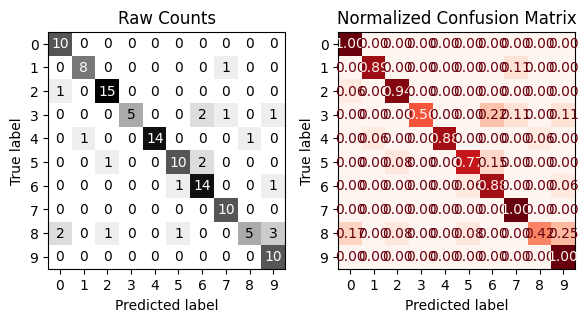

precision    recall  f1-score     support
Train 0              0.796610  0.979167  0.878505   48.000000
      1              0.769231  0.952381  0.851064   42.000000
      2              0.923077  0.960000  0.941176   75.000000
      3              0.894737  0.447368  0.596491   38.000000
      4              0.911765  0.794872  0.849315   78.000000
      5              0.864407  0.809524  0.836066   63.000000
      6              0.786517  0.921053  0.848485   76.000000
      7              0.954545  0.954545  0.954545   44.000000
      8              0.863636  0.666667  0.752475   57.000000
      9              0.773585  0.931818  0.845361   44.000000
      accuracy       0.849558  0.849558  0.849558    0.849558
      macro avg      0.853811  0.841739  0.835348  565.000000
      weighted avg   0.857330  0.849558  0.843643  565.000000
Test  0              0.769231  1.000000  0.869565   10.000000
      1              0.888889  0.888889  0.888889    9.000000
      2              0.882353  0.937500  0.909091   16.000000
      3              1.000000  0.555556  0.714286    9.000000
      4              1.000000  0.875000  0.933333   16.000000
      5              0.833333  0.769231  0.800000   13.000000
      6              0.777778  0.875000  0.823529   16.000000
      7              0.833333  1.000000  0.909091   10.000000
      8              0.833333  0.416667  0.555556   12.000000
      9              0.666667  1.000000  0.800000   10.000000
      accuracy       0.834711  0.834711  0.834711    0.834711
      macro avg      0.848492  0.831784  0.820334  121.000000
      weighted avg   0.851965  0.834711  0.825926  121.000000

In [ ]:
# Evaluate the results

train_dict, test_dict = evaluate_classification_network(model_5_reduce,
                                                        X_train=train_ds,
                                                        X_test=test_ds,
                                                        history=history_5,
                                                        output_dict=True)

# Use helper function to get results in a DataFrame

results_model_5 = make_results_df(train_dict, test_dict)
results_model_5

In [ ]:
# Compare the current model with the best model so far (Model #3)

compare_models(results_model_3, results_model_5)

Train accuracy decreased by -0.015929203539822967
Test accuracy decreased by -0.008264462809917328
Overfitting decreased by -0.007664740729905639
*Overfitting is calculated as train accuracy - test acccuracy


Observation:

This is the best model so far, with no overfitting, one of the best test accuracy, and has the potential to continue training more epochs to further improve the model. Next, I will try training the ResNet50V2's higher level layers.

-------
# Model #6: Tune ResNet50v2

### a) Augmentation: RandomFlip, RandomRotation, RandomZoom, RandomTranslation

### b) Regularization: Dropout, BatchNormalization

### c) (KEEP) More Units to introduce Complexity

### d) (KEEP) Add more Layer to add Complexity

### e) (KEEP) Add more Layers, reduce number of Units in a funnel-shape

### f) (NEW) Train ResNet50v2's later layers
-------

In [ ]:
# Allow the pretained layer to be trainable again

resnet50v2_pretrained.trainable = True

# Freeze only the early layers:
for layer in resnet50v2_pretrained.layers[:140]:
    layer.trainable = False
for layer in resnet50v2_pretrained.layers[140:]:
    layer.trainable = True

# Define a data augmentation layer

data_augmentation = tf.keras.Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.5),
    RandomZoom(0.1),
    RandomTranslation(0.1, 0.1)
], name='data_augmentation')


# Build model

def build_model_6_trainres():
  model = Sequential()
  model.add(Input(shape=INPUT_SHAPE))
  model.add(data_augmentation)
  model.add(Lambda(resnetv2_preprocessor))
  model.add(resnet50v2_pretrained)
  model.add(Dense(128, activation=None))
  model.add(BatchNormalization())
  model.add(ReLU())
  model.add(Dropout(0.1))
  model.add(Dense(64, activation=None))
  model.add(BatchNormalization())
  model.add(ReLU())
  model.add(Dropout(0.1))
  model.add(Dense(32, activation=None))
  model.add(BatchNormalization())
  model.add(ReLU())
  model.add(Dropout(0.1))
  model.add(Dense(len(class_names), activation='softmax'))

  model.compile(optimizer=Adam(learning_rate=.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

  model.summary()
  return model


# Make an instance of the model

model_6_trainres = build_model_6_trainres()
model_6_trainres.summary()

Model: "sequential_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ data_augmentation (Sequential)  │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_23 (Lambda)              │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50v2 (Functional)         │ (None, 2048)           │    23,564,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_58 (Dense)                │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_32          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_32 (ReLU)                 │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_33 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_59 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_33          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_33 (ReLU)                 │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_34 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_60 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_34          │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_34 (ReLU)                 │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_35 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_61 (Dense)                │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,838,634 (90.94 MB)

 Trainable params: 16,625,642 (63.42 MB)

 Non-trainable params: 7,212,992 (27.52 MB)

Model: "sequential_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ data_augmentation (Sequential)  │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_23 (Lambda)              │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50v2 (Functional)         │ (None, 2048)           │    23,564,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_58 (Dense)                │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_32          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_32 (ReLU)                 │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_33 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_59 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_33          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_33 (ReLU)                 │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_34 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_60 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_34          │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_34 (ReLU)                 │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_35 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_61 (Dense)                │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,838,634 (90.94 MB)

 Trainable params: 16,625,642 (63.42 MB)

 Non-trainable params: 7,212,992 (27.52 MB)

In [ ]:
# Fit the model

# Save the best model to disk every time it improves

checkpoint_cb = ModelCheckpoint(
    filepath="/content/drive/MyDrive/Colab Notebooks/project_koi_classification/best_models/best_koi_model.h5",   # where to save
    monitor="val_accuracy",
    save_best_only=True,
    mode="max",
    verbose=1
)

# Reduce learning rate when val_loss plateaus

reduce_lr_cb = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,           # multiply lr by this factor when triggered
    patience=3,           # wait this many epochs with no improvement
    min_lr=1e-6,          # lower bound on lr
    verbose=1
)


history_6 = model_6_trainres.fit(train_ds, validation_data=test_ds, epochs=100,
                                callbacks=[checkpoint_cb, reduce_lr_cb])

Epoch 1/100
35/36 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.1080 - loss: 2.4849
Epoch 1: val_accuracy improved from -inf to 0.14876, saving model to /content/drive/MyDrive/Colab Notebooks/project_koi_classification/best_models/best_koi_model.h5


36/36 ━━━━━━━━━━━━━━━━━━━━ 20s 124ms/step - accuracy: 0.1109 - loss: 2.4752 - val_accuracy: 0.1488 - val_loss: 2.2444 - learning_rate: 1.0000e-04
Epoch 2/100
35/36 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.3005 - loss: 1.9748
Epoch 2: val_accuracy improved from 0.14876 to 0.42149, saving model to /content/drive/MyDrive/Colab Notebooks/project_koi_classification/best_models/best_koi_model.h5


36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - accuracy: 0.3009 - loss: 1.9715 - val_accuracy: 0.4215 - val_loss: 1.8219 - learning_rate: 1.0000e-04
Epoch 3/100
35/36 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.3970 - loss: 1.7439
Epoch 3: val_accuracy improved from 0.42149 to 0.56198, saving model to /content/drive/MyDrive/Colab Notebooks/project_koi_classification/best_models/best_koi_model.h5


36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 78ms/step - accuracy: 0.3991 - loss: 1.7404 - val_accuracy: 0.5620 - val_loss: 1.4467 - learning_rate: 1.0000e-04
Epoch 4/100
35/36 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5538 - loss: 1.4933
Epoch 4: val_accuracy improved from 0.56198 to 0.70248, saving model to /content/drive/MyDrive/Colab Notebooks/project_koi_classification/best_models/best_koi_model.h5


36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - accuracy: 0.5536 - loss: 1.4937 - val_accuracy: 0.7025 - val_loss: 1.1921 - learning_rate: 1.0000e-04
Epoch 5/100
35/36 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5892 - loss: 1.3950
Epoch 5: val_accuracy did not improve from 0.70248
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.5911 - loss: 1.3931 - val_accuracy: 0.6777 - val_loss: 1.1404 - learning_rate: 1.0000e-04
Epoch 6/100
35/36 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.6446 - loss: 1.3479
Epoch 6: val_accuracy did not improve from 0.70248
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.6461 - loss: 1.3444 - val_accuracy: 0.7025 - val_loss: 1.0371 - learning_rate: 1.0000e-04
Epoch 7/100
35/36 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.7402 - loss: 1.1540
Epoch 7: val_accuracy improved from 0.70248 to 0.71901, saving model to /content/drive/MyDrive/Colab Notebooks/project_koi_classification/best_models/best_koi_model.h5


36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - accuracy: 0.7382 - loss: 1.1558 - val_accuracy: 0.7190 - val_loss: 0.9313 - learning_rate: 1.0000e-04
Epoch 8/100
35/36 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.7025 - loss: 1.1434
Epoch 8: val_accuracy improved from 0.71901 to 0.80992, saving model to /content/drive/MyDrive/Colab Notebooks/project_koi_classification/best_models/best_koi_model.h5


36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - accuracy: 0.7039 - loss: 1.1432 - val_accuracy: 0.8099 - val_loss: 0.8770 - learning_rate: 1.0000e-04
Epoch 9/100
35/36 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.7329 - loss: 1.1183
Epoch 9: val_accuracy did not improve from 0.80992
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.7339 - loss: 1.1161 - val_accuracy: 0.7851 - val_loss: 0.8250 - learning_rate: 1.0000e-04
Epoch 10/100
35/36 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.7712 - loss: 1.0330
Epoch 10: val_accuracy did not improve from 0.80992
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.7714 - loss: 1.0328 - val_accuracy: 0.8017 - val_loss: 0.8360 - learning_rate: 1.0000e-04
Epoch 11/100
35/36 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.8252 - loss: 0.9885
Epoch 11: val_accuracy did not improve from 0.80992
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.8249 - loss: 0.9881 - val_accuracy: 0.8099 - val_loss: 0.7883 - learning_rate: 1.0000e-04
Epoch 12/

36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - accuracy: 0.8408 - loss: 0.9303 - val_accuracy: 0.8347 - val_loss: 0.7612 - learning_rate: 1.0000e-04
Epoch 13/100
35/36 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.8647 - loss: 0.8793
Epoch 13: val_accuracy improved from 0.83471 to 0.87603, saving model to /content/drive/MyDrive/Colab Notebooks/project_koi_classification/best_models/best_koi_model.h5


36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - accuracy: 0.8635 - loss: 0.8804 - val_accuracy: 0.8760 - val_loss: 0.7008 - learning_rate: 1.0000e-04
Epoch 14/100
35/36 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.8402 - loss: 0.8821
Epoch 14: val_accuracy improved from 0.87603 to 0.88430, saving model to /content/drive/MyDrive/Colab Notebooks/project_koi_classification/best_models/best_koi_model.h5


36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - accuracy: 0.8400 - loss: 0.8818 - val_accuracy: 0.8843 - val_loss: 0.7329 - learning_rate: 1.0000e-04
Epoch 15/100
35/36 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.8098 - loss: 0.8773
Epoch 15: val_accuracy did not improve from 0.88430
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.8106 - loss: 0.8758 - val_accuracy: 0.8347 - val_loss: 0.6924 - learning_rate: 1.0000e-04
Epoch 16/100
35/36 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.8478 - loss: 0.7894
Epoch 16: val_accuracy did not improve from 0.88430
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.8476 - loss: 0.7914 - val_accuracy: 0.8760 - val_loss: 0.6876 - learning_rate: 1.0000e-04
Epoch 17/100
35/36 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.8441 - loss: 0.7941
Epoch 17: val_accuracy did not improve from 0.88430
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.8442 - loss: 0.7948 - val_accuracy: 0.8760 - val_loss: 0.6561 - learning_rate: 1.0000e-04
Epoch 1

36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - accuracy: 0.8796 - loss: 0.7597 - val_accuracy: 0.9008 - val_loss: 0.6034 - learning_rate: 1.0000e-04
Epoch 19/100
35/36 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.8917 - loss: 0.7369
Epoch 19: val_accuracy did not improve from 0.90083
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.8904 - loss: 0.7382 - val_accuracy: 0.8595 - val_loss: 0.5664 - learning_rate: 1.0000e-04
Epoch 20/100
35/36 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.8899 - loss: 0.7126
Epoch 20: val_accuracy did not improve from 0.90083
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.8888 - loss: 0.7137 - val_accuracy: 0.8678 - val_loss: 0.5829 - learning_rate: 1.0000e-04
Epoch 21/100
35/36 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9349 - loss: 0.6063
Epoch 21: val_accuracy improved from 0.90083 to 0.91736, saving model to /content/drive/MyDrive/Colab Notebooks/project_koi_classification/best_models/best_koi_model.h5


36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - accuracy: 0.9339 - loss: 0.6078 - val_accuracy: 0.9174 - val_loss: 0.5231 - learning_rate: 1.0000e-04
Epoch 22/100
35/36 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.8969 - loss: 0.6648
Epoch 22: val_accuracy did not improve from 0.91736
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.8970 - loss: 0.6641 - val_accuracy: 0.9008 - val_loss: 0.5128 - learning_rate: 1.0000e-04
Epoch 23/100
35/36 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.9022 - loss: 0.6405
Epoch 23: val_accuracy did not improve from 0.91736
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.9018 - loss: 0.6406 - val_accuracy: 0.8926 - val_loss: 0.5503 - learning_rate: 1.0000e-04
Epoch 24/100
35/36 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.9045 - loss: 0.5713
Epoch 24: val_accuracy did not improve from 0.91736
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.9045 - loss: 0.5717 - val_accuracy: 0.8843 - val_loss: 0.6039 - learning_rate: 1.0000e-04
Epoch 2

36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 93ms/step - accuracy: 0.9472 - loss: 0.4352 - val_accuracy: 0.9339 - val_loss: 0.4226 - learning_rate: 1.2500e-05
Epoch 52/100
35/36 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9524 - loss: 0.4229
Epoch 52: val_accuracy did not improve from 0.93388
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.9525 - loss: 0.4226 - val_accuracy: 0.9256 - val_loss: 0.4185 - learning_rate: 1.2500e-05
Epoch 53/100
35/36 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.9645 - loss: 0.3960
Epoch 53: val_accuracy did not improve from 0.93388
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.9643 - loss: 0.3964 - val_accuracy: 0.9256 - val_loss: 0.4213 - learning_rate: 1.2500e-05
Epoch 54/100
35/36 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9534 - loss: 0.4086
Epoch 54: val_accuracy did not improve from 0.93388
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.9532 - loss: 0.4094 - val_accuracy: 0.9008 - val_loss: 0.4336 - learning_rate: 1.2500e-05
Epoch 5


- Evaluating Network...
----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        48
           1       1.00      1.00      1.00        42
           2       1.00      1.00      1.00        75
           3       0.81      1.00      0.89        38
           4       0.99      0.90      0.94        78
           5       1.00      1.00      1.00        63
           6       1.00      0.95      0.97        76
           7       1.00      1.00      1.00        44
           8       0.95      0.98      0.97        57
           9       1.00      1.00      1.00        44

    accuracy                           0.98       565
   macro avg       0.97      0.98      0.98       565
weighted avg       0.98      0.98      0.98       565



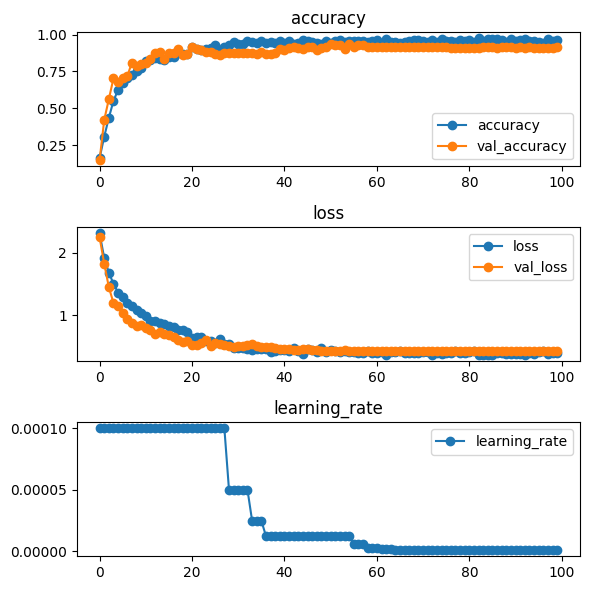

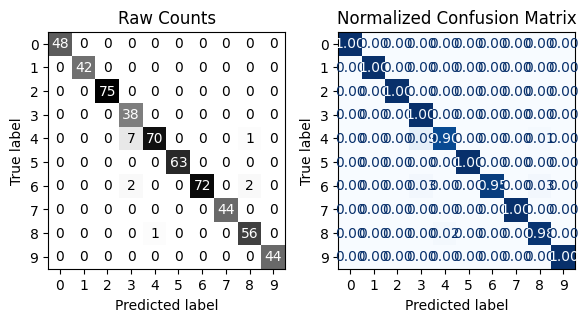

----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00         9
           2       0.94      1.00      0.97        16
           3       0.80      0.89      0.84         9
           4       0.93      0.88      0.90        16
           5       0.73      0.85      0.79        13
           6       1.00      0.75      0.86        16
           7       1.00      1.00      1.00        10
           8       0.92      0.92      0.92        12
           9       0.91      1.00      0.95        10

    accuracy                           0.92       121
   macro avg       0.92      0.93      0.92       121
weighted avg       0.92      0.92      0.92       121



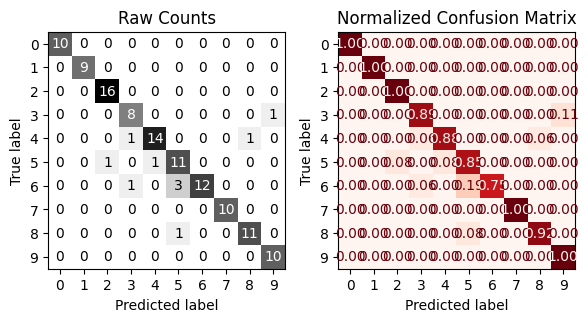

precision    recall  f1-score     support
Train 0              1.000000  1.000000  1.000000   48.000000
      1              1.000000  1.000000  1.000000   42.000000
      2              1.000000  1.000000  1.000000   75.000000
      3              0.808511  1.000000  0.894118   38.000000
      4              0.985915  0.897436  0.939597   78.000000
      5              1.000000  1.000000  1.000000   63.000000
      6              1.000000  0.947368  0.972973   76.000000
      7              1.000000  1.000000  1.000000   44.000000
      8              0.949153  0.982456  0.965517   57.000000
      9              1.000000  1.000000  1.000000   44.000000
      accuracy       0.976991  0.976991  0.976991    0.976991
      macro avg      0.974358  0.982726  0.977221  565.000000
      weighted avg   0.980047  0.976991  0.977426  565.000000
Test  0              1.000000  1.000000  1.000000   10.000000
      1              1.000000  1.000000  1.000000    9.000000
      2              0.941176  1.000000  0.969697   16.000000
      3              0.800000  0.888889  0.842105    9.000000
      4              0.933333  0.875000  0.903226   16.000000
      5              0.733333  0.846154  0.785714   13.000000
      6              1.000000  0.750000  0.857143   16.000000
      7              1.000000  1.000000  1.000000   10.000000
      8              0.916667  0.916667  0.916667   12.000000
      9              0.909091  1.000000  0.952381   10.000000
      accuracy       0.917355  0.917355  0.917355    0.917355
      macro avg      0.923360  0.927671  0.922693  121.000000
      weighted avg   0.924102  0.917355  0.917340  121.000000

In [ ]:
# Evaluate the results

train_dict, test_dict = evaluate_classification_network(model_6_trainres,
                                                        X_train=train_ds,
                                                        X_test=test_ds,
                                                        history=history_6,
                                                        output_dict=True)

# Use helper function to get results in a DataFrame

results_model_6 = make_results_df(train_dict, test_dict)
results_model_6

In [ ]:
# Compare the current model with the best model so far (Model #5)

compare_models(results_model_5, results_model_6)

Train accuracy increased by 0.12743362831858407
Test accuracy increased by 0.08264462809917361
Overfitting increased by 0.04478900021941046
*Overfitting is calculated as train accuracy - test acccuracy


In [ ]:
test_preds = model_6_trainres.predict(test_ds)
